In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

plt.rcParams.update({'font.size': 12})

# PFI

In [ ]:
# Load meg channel config
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

In [ ]:
# load gradient analysis results
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'grads.npy')

grads = np.load(path)
pfi = np.abs(grads).transpose(0, 2, 1)
pfits = np.mean(pfi, axis=2)

# convolve pfits with summation kernel
kernel = np.ones(24) / 24

# use convolution which operates on last axis
pfits = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), -1, pfits)

time_range = np.arange(-100, 924, 4)

In [ ]:
pfits.shape

In [ ]:
# load pfi data
path = os.path.join('..', 'results', 'cichy_epoched', 'all_noshuffle_wavenetclass_semb10_drop0.4', 'groupPFI',
                    'val_loss_PFIch4.npy')
pfi = np.load(open(path, 'rb'))
pfi = pfi[0, 0, 0] - pfi[:, :, 1:]

time_range = np.arange(-48, 872, 4)

In [ ]:
# PFIts
path = os.path.join('..', 'results', 'cichy_epoched', 'all_noshuffle_wavenetclass_semb10_drop0.4', 'groupPFI',
                    'val_loss_PFIts.npy')
pfits = np.load(open(path, 'rb'))
pfits = pfits[0, 0] - pfits

In [ ]:
# times array
times = np.array([time_range for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# channels array
pfi_pd = pfi.reshape(-1, pfi.shape[2])

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=(0, 1)))
mags = np.array([mags/np.max(mags[:-1]) for _ in range(pfi_pd.shape[0])])
mags = mags.reshape(-1)

pfi_pd = pfi_pd.reshape(-1)

In [ ]:
# put everything in a pd dataframe
pd_dict = {'Gradient magnitude': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'channels': ['individual']*mags.shape[0]}
pfi_pd = pd.DataFrame(pd_dict)

In [ ]:
times = np.array([time_range for _ in range(pfits.shape[0])])
pfits_pd = pfits.reshape(-1)
times = times.reshape(-1)
mags_ts = [np.max(mags)] * times.shape[0]
channels = ['aggregate'] * times.shape[0]
inds = list(range(mags.shape[0], mags.shape[0]+times.shape[0]))
pfits_pd = pd.DataFrame({'Gradient magnitude': pfits_pd, 'Time (ms)': times, 'relative magnitude': mags_ts, 'channels': channels}, index=inds)
pfi_pd = pd.concat((pfi_pd, pfits_pd))

In [ ]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfits_pd, kind="line",
    x="Time (ms)", y="Gradient magnitude", hue='relative magnitude', n_boot=10, legend=None, aspect=1.1
)
#plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/temporal_PFI.pdf', format='pdf')

In [ ]:
pfi_pd

In [ ]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", size='channels', style='channels', size_order=['aggregate', 'individual'],
    x="Time (ms)", y="Accuracy loss", hue='relative magnitude', n_boot=10, legend='brief', palette='Reds', aspect=2
)

handles, labels = plt.gca().get_legend_handles_labels()
pfi_plot._legend.remove()
plt.legend(handles[-3:], labels[-3:])

In [ ]:
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/channelwise_PFI.svg', format='svg')

# Accuracies

In [ ]:
df = pd.read_csv('excel_data.txt', sep="\t", header=0)
df = df.stack().reset_index()
df = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

model_type = []
for i in range(len(df)):
    if 'finetuned' in df['model'][i]:
        model_type.append('finetuned')
    elif 'emb' in df['model'][i]:
        model_type.append('group\nembedding')
    elif 'group' in df['model'][i]:
        model_type.append('group')
    else:
        model_type.append('subject')
df['model type'] = model_type

In [ ]:
df[df['model']=='nonlin-group-emb']

In [ ]:
%matplotlib widget
'''
rows = df.loc[df['model type'] == 'subject']
g = sns.catplot(kind="violin", data=rows, cut=0, ci=None, scale='width', y='Validation accuracy', x='model')

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
ax.axhline(0.33, ls='--', color='black', label='peak sliding accuracy')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('')
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/subject_acc.svg', format='svg')
'''

plt.rcParams.update({'font.size': 12})
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plot_params = {
    'kind':    'violin',
    'aspect':  2.1,
    'cut':     0,
    'ci':      None,
    'scale':   'area',
    'hue':     'model type',
    'dodge':   False,
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
plt.ylim(0, 1)
plt.xlabel('')
plt.text(7.7,0.015,'chance')
plt.xticks(plt.xticks()[0], ['linear\nsubject',
                             'nonlinear\nsubject',
                             'linear\ngroup',
                             'nonlinear\ngroup',
                             'linear\ngroup-emb',
                             'nonlinear\ngroup-emb',
                             'nonlinear\ngroup\nfinetuned',
                             'nonlinear\ngroup-emb\nfinetuned'])

# add extra padding below plot and to the left of the y-axis
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)

ymin = 0.02
ymax = 0.7
alpha = 0.5
dash = '--'
color = 'red'
ax.axvline(1.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(3.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(5.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
plt.text(0.22,0.87,'subject models')
plt.text(2,0.8,'group models')
plt.text(3.7,0.8,'group models\nwith embedding')
plt.text(5.6,0.8,'finetuned\ngroup models')

# which pairs to computer stats on
pairs = [('lin-subject', 'nonlin-subject'),
         ('lin-subject', 'nonlin-group-emb'),
         ('lin-subject', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group-emb finetuned'),
         ('nonlin-group finetuned', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()
e=0
plt.savefig('group_acc.pdf', format='pdf')

# Generalization to new subject

In [28]:
path = os.path.join('..', 'results', 'cichy_epoched', 'indiv_wavenetlinear_MNN', 'val_loss_general.npy')
accs = np.load(path)
train1 = [0.591525424, 0.303672316, 0.121468925, 0.680790966, 0.885593221, 0.662429377, 0.730225995, 0.159604517, 0.579096052, 0.627118642, 0.223163842, 0.151129942, 0.06497175, 0.483050848, 0.412429377]
accs = np.concatenate((accs, np.array(train1).reshape(-1, 1)), axis=1)
chance = [0.00847] * 15
accs = np.concatenate((np.array(chance).reshape(-1, 1), accs), axis=1)

In [29]:
accs_df = pd.DataFrame(accs)
accs_df = accs_df.stack().reset_index()
accs_df = accs_df.rename(columns={'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'})
accs_df['level'] = ['linear subject'] * len(accs_df)

In [ ]:
accs_df

In [14]:
def create_df(accsg, level):
    # need to get actual subjects
    order = [10, 7, 3, 11, 8, 4, 12, 9, 5, 13, 1, 14, 2, 6, 0]
    accsg_df = pd.DataFrame(accsg[order, :])
    accsg_df = accsg_df.stack().reset_index()
    accsg_df = accsg_df.rename(columns={'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'})
    accsg_df['level'] = [level] * len(accsg_df)
    
    return accsg_df

In [30]:
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_general.txt.npy')
accsg = np.load(path)
group_emb = create_df(accsg, 'nonlinear group-emb')

path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_general.txt.npy')
accsg = np.load(path)
group = create_df(accsg, 'nonlinear group')


path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_subs_general.txt.npy')
accsg = np.mean(np.load(path), axis=2)
group_emb_all = create_df(accsg, 'group-emb all')

path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_subs_general.txt.npy')
accsg = np.mean(np.load(path), axis=2)
group_all = create_df(accsg, 'group all')

In [31]:
df = pd.concat((accs_df, group_emb, group), ignore_index=True)

In [ ]:
df[(df['subject'] == 14) & (df['level'] == 'group')]

In [ ]:
df

In [ ]:
df[df['subject'] == 14]

In [17]:
df['Training ratio'] = df['Training ratio'].astype(float)/10

In [36]:
df['level'] == 'group all'

0      False
1      False
2      False
3      False
4      False
       ...  
490    False
491    False
492    False
493    False
494    False
Name: level, Length: 495, dtype: bool

In [37]:
p_values = []
for i in range(11):
    test1 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group')]
    test2 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group-emb')]

    p_values.append(stats.ttest_rel(test1, test2)[1] * 11)

Ttest_relResult(statistic=1.2501156609257873, pvalue=0.23175050414709836)
Ttest_relResult(statistic=-3.1820540255811807, pvalue=0.006653812458089227)
Ttest_relResult(statistic=-4.087200449355965, pvalue=0.0011095305038733407)
Ttest_relResult(statistic=-2.5380344727651876, pvalue=0.023659874754797996)
Ttest_relResult(statistic=-1.0812489328347485, pvalue=0.2978603263706095)
Ttest_relResult(statistic=-3.660134188496471, pvalue=0.0025726626725950962)
Ttest_relResult(statistic=-1.8124881787276597, pvalue=0.09140619724454746)
Ttest_relResult(statistic=-1.1652391397908008, pvalue=0.2633924822574126)
Ttest_relResult(statistic=-1.9083710777682745, pvalue=0.07706201126265527)
Ttest_relResult(statistic=-1.9079571136271043, pvalue=0.07711931377952543)
Ttest_relResult(statistic=-0.8839758001827438, pvalue=0.39163740571329986)


In [38]:
p_values

[2.549255545618082,
 0.0731919370389815,
 0.012204835542606748,
 0.26025862230277796,
 3.2764635900767045,
 0.02829928939854606,
 1.005468169690022,
 2.8973173048315384,
 0.847682123889208,
 0.8483124515747796,
 4.308011462846299]

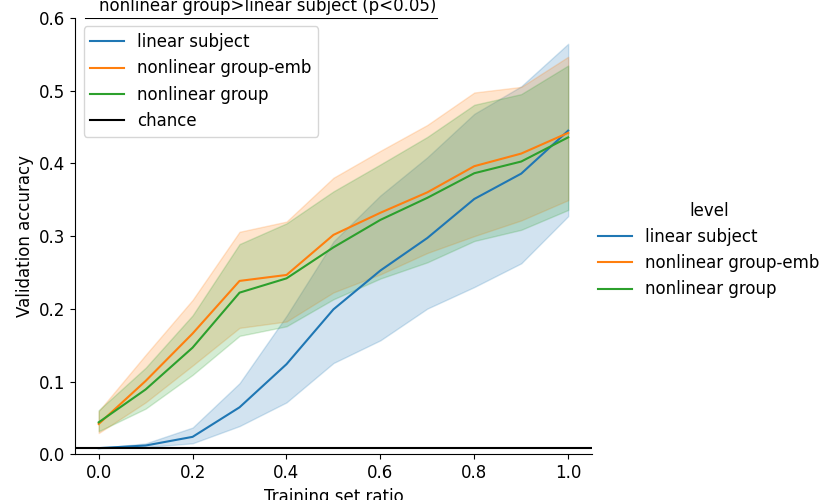

In [24]:
%matplotlib widget
g = sns.relplot(
    data=df, kind="line", hue='level',
    x="Training ratio", y="Validation accuracy", n_boot=1000, aspect=1.2, ci=95
)
ax = g.axes[0][0]
plt.axhline(0.6, 0.02, 0.7, color='black')
plt.text(0,0.61,'nonlinear group>linear subject (p<0.05)')
plt.ylim(0, 0.6)
plt.xlabel('Training set ratio')



ax.axhline(0.008, ls='-', color='black', label='chance')
ax.legend(loc='upper left')

In [ ]:
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/generalization.pdf', format='pdf')